### Imports

In [2]:
import matplotlib
import parselmouth
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa
from librosa.display import specshow, waveplot
import pandas as pd
from matplotlib import gridspec
from IPython.display import Audio
import scipy.signal as sig
sns.set_theme()

### Define Parameters and Variables

<ul>
    <li>start_time - start time of the segment that is to be plotted (seconds)</li>
    <li>end_time - end time of the segment that is to be plotted (seconds)</li>
    <li>sarod_audio_path - path to audio file of only sarod</li>
    <li>mix_audio_path - path to the mix audio file to be analysed</li>
    <li>cycle_file - path to the file with annotation of sums in the song</li>
    <li>gat_annotation file - path to file with a list of annotations in the song</li>
    <li>onset_file - path to file with sarod and tabla onsets</li>
</ul>

In [3]:
start_time = 277
end_time = 294.7
sarod_audio_path = 'Data/NIR_PrB_Jhinjhoti_2Gats_Sarod.wav'
tabla_audio_path = 'Data/NIR_PrB_Jhinjhoti_2Gats_Tabla.wav'
mix_audio_path = 'Data/NIR_PrB_Jhinjhoti_2Gats_StereoMix.wav'
cycle_file = 'Data/NIR_PrB_jhinjhoti_2Gats_Metre_Rupak.csv'
gat_annotation_file = 'Data/NIR_PrB_Jhinjhoti_2Gats_Annotation.csv'
onset_file = 'Data/NIR_PrB_Jhinjhoti_2Gats_Onsets_Selected_Rupak.csv'

We load only the relevant part of the audio file here. Audio is loaded in mono, and sample rate is unchanged.

In [4]:
sarod_audio, sarod_sr = librosa.load(sarod_audio_path, sr=None, mono=True, offset=start_time, duration = end_time - start_time)
cycle_df = pd.read_csv(cycle_file)
index_values = cycle_df.loc[(cycle_df['Time'] >= start_time) & (cycle_df['Time'] <= end_time)].index.values
annotated_beats = cycle_df.iloc[max(index_values[0]-1, 0):min(index_values[-1]+2, cycle_df.shape[0])]
# add all matras to show - each annotated beat has 7 divisions
matras = []
for ind, beats in enumerate(annotated_beats['Time'].values[:-1]):
    matras.extend(np.around(np.linspace(beats, annotated_beats['Time'].values[ind+1], num = 7, endpoint=False), 2)[1:])

Extract sarod and tabla onsets from the annotation file

In [5]:
onset_vals = pd.read_csv(onset_file)
sarod_onset_vals = onset_vals.loc[(onset_vals['Inst'] >= start_time) & (onset_vals['Inst'] <= end_time)]
tabla_onset_vals = onset_vals.loc[(onset_vals['Tabla'] >= start_time) & (onset_vals['Tabla'] <= end_time)]

Extract gat annotations present between start_time and end_time

In [6]:
annotations = pd.read_csv(gat_annotation_file, header=None)
annotations.columns = ['Type', 'Start Time', 'End Time', 'Duration', 'Label']
annotations = annotations.loc[((annotations['Start Time'] >= start_time) & (annotations['Start Time'] <= end_time)) &
                              ((annotations['End Time'] >= start_time) & (annotations['End Time'] <= end_time)) &
                              ((annotations['Type'] == 'SAROD') | (annotations['Type'] == 'TABLA') | (annotations['Type'] == 'INTERACTION'))
                             ]

Use the sarod and tabla audio to generate spectograms

In [7]:
#spectogram (created using the stereo mix audio)
sarod_audio, sarod_sr = librosa.load(sarod_audio_path, sr=None, mono=True, offset=start_time, duration = end_time - start_time)
tabla_audio, tabla_sr = librosa.load(tabla_audio_path, sr=None, mono=True, offset=start_time, duration = end_time - start_time)
mix_audio, mix_sr = librosa.load(mix_audio_path, sr=None, mono=True, offset=start_time, duration = end_time - start_time)
# stft params
winsize = int(np.ceil(mix_sr*40e-3))
hopsize = int(np.ceil(mix_sr*10e-3))
nfft = int(2**np.ceil(np.log2(winsize)))
# extract spectogram
f_sarod,t_sarod,X_sarod = sig.stft(sarod_audio, fs=sarod_sr, window='hann', nperseg=winsize, noverlap=(winsize-hopsize), nfft=nfft)
X_sarod_dB = librosa.power_to_db(np.abs(X_sarod), ref = np.max, amin=1e-5)
f_tabla,t_tabla,X_tabla = sig.stft(tabla_audio, fs=tabla_sr, window='hann', nperseg=winsize, noverlap=(winsize-hopsize), nfft=nfft)
X_tabla_dB = librosa.power_to_db(np.abs(X_tabla), ref = np.max, amin=1e-5)

Play the audio being analysed

In [8]:
Audio(mix_audio, rate=mix_sr)

Plotting the spectograms of tabla and sarod

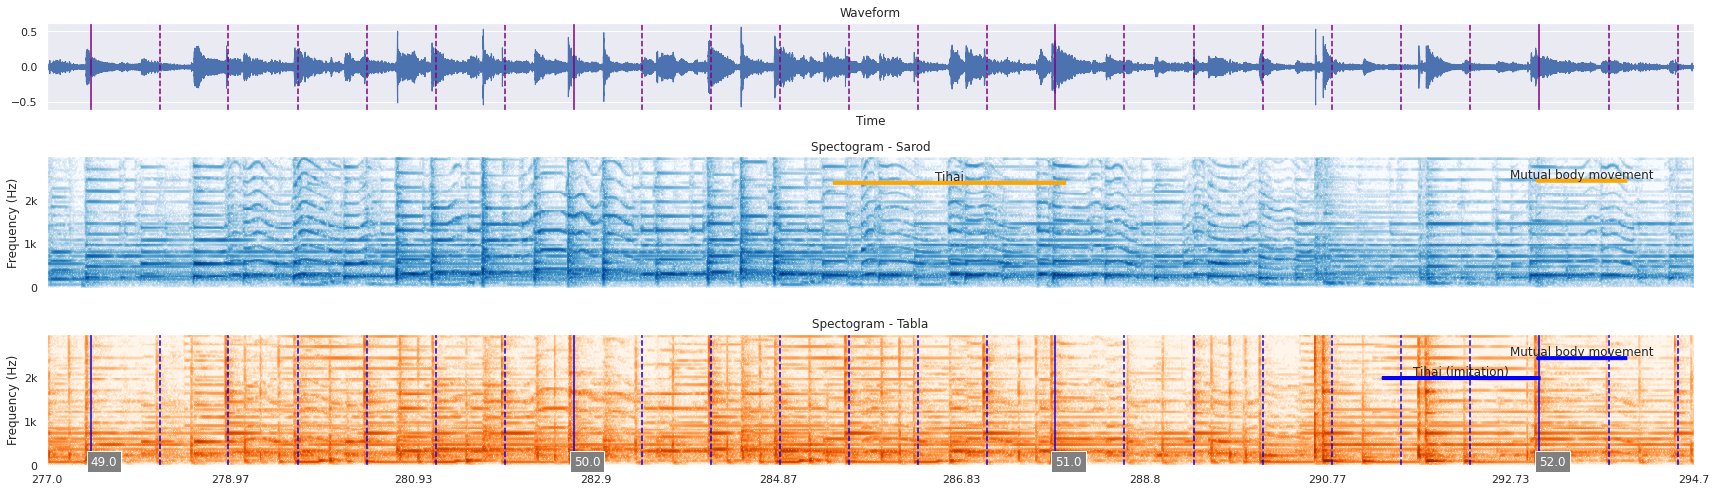

In [29]:
fig = plt.figure(figsize=(24, 7))
specs = fig.add_gridspec(3, 1, height_ratios = [2, 3, 3])
axs = [fig.add_subplot(specs[0, 0]), fig.add_subplot(specs[1, 0]), fig.add_subplot(specs[2, 0])]
#plot the waveform
waveplot(mix_audio, mix_sr, ax=axs[0])
axs[0].set(title='Waveform')
#plot spectograms
specshow(X_sarod_dB, x_axis='time', y_axis='linear', sr=sarod_sr, fmax=sarod_sr//2, hop_length=hopsize, ax=axs[1], cmap='Blues')
axs[1].set(ylabel='Frequency (Hz)', xlabel='', title='Spectogram - Sarod')
specshow(X_tabla_dB, x_axis='time', y_axis='linear', sr=tabla_sr, fmax=tabla_sr//2, hop_length=hopsize, ax=axs[2], cmap='Oranges')
axs[2].set(ylabel='Frequency (Hz)', xlabel='', title='Spectogram - Tabla')
for i, beat in annotated_beats.iterrows():
    # plot annotated beats
    if beat['Time'] >= start_time and beat['Time'] <= end_time:
        axs[0].axvline(beat['Time']-start_time, linestyle='-', c='purple')
        axs[2].axvline(beat['Time']-start_time, linestyle='-', c='blue')
        axs[2].annotate(beat['Cycle'], (beat['Time']-start_time, -0.4), bbox=dict(facecolor='grey', edgecolor='white'), c='white')
for matra in matras:
    # plot beats in the middle
    if matra >= start_time and matra <= end_time:
        axs[0].axvline(matra-start_time, linestyle='--', c='purple')
        axs[2].axvline(matra-start_time, linestyle='--', c='blue')
for i, annotation in annotations.iterrows():
    rand = np.random.random()# random vertical displacement for the label
    if annotation['Type'] == 'SAROD' or annotation['Type'] == 'INTERACTION':
        axs[1].annotate('', xy=(annotation['Start Time'] - start_time, 2450 - 500*rand), xytext=(annotation['End Time'] - start_time, 2450 - 500*rand), arrowprops={'headlength': 0.4, 'headwidth': 0.2, 'width': 3, 'ec':'orange', 'fc': 'orange'})
        axs[1].annotate(annotation['Label'], (annotation['Start Time']-start_time+annotation['Duration']/2, 2500 - 500*rand), ha='center')
    if annotation['Type'] == 'TABLA' or annotation['Type'] == 'INTERACTION':
        axs[2].annotate('', xy=(annotation['Start Time'] - start_time, 2450 - 500*rand), xytext=(annotation['End Time'] - start_time, 2450 - 500*rand), arrowprops={'headlength': 0.4, 'headwidth': 0.2, 'width': 3, 'ec':'blue', 'fc': 'blue'})
        axs[2].annotate(annotation['Label'], (annotation['Start Time'] - start_time + (annotation['Duration']/2), 2500 - 500*rand), ha='center')
axs[2].set_xlim(0, end_time-start_time)
axs[2].set_xticks(np.linspace(0, end_time-start_time, 10))
axs[2].set_xticklabels(np.around(np.linspace(0, end_time-start_time, 10) + start_time, 2))
axs[1].set_xticks([])
axs[1].set_xlim(axs[2].get_xlim())
axs[0].set_xticks([])
axs[0].set_xlim(axs[1].get_xlim())
axs[1].set_ylim(0, 3000)
axs[1].set_yticks([0, 1e3, 2e3])
axs[1].set_yticklabels(['0', '1k', '2k'])
axs[2].set_ylim(0, 3000)
axs[2].set_yticks([0, 1e3, 2e3])
axs[2].set_yticklabels(['0', '1k', '2k'])
fig.tight_layout()

Audio mixed with clicks at the sitar onset points
lower pitch - tabla, higher pitch - sarod

In [11]:
click_track_sarod = librosa.clicks(sarod_onset_vals['Inst'].values-start_time, sr=mix_sr, length=len(sarod_audio), click_freq=3000)
click_track_tabla = librosa.clicks(tabla_onset_vals['Tabla'].values-start_time, sr=mix_sr, length=len(sarod_audio), click_freq=1000)
Audio(0.7*mix_audio + 0.15*click_track_sarod + 0.15*click_track_tabla, rate=mix_sr)

Audio with just sarod clicks

In [12]:
Audio(0.8*sarod_audio + 0.2*click_track_sarod, rate=sarod_sr)

Audio with just tabla clicks

In [13]:
Audio(0.8*tabla_audio + 0.2*click_track_tabla, rate=sarod_sr)